In [1]:
import os, utils
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from model.modelmlp import ModelMLP
from tqdm import tqdm
from losses.losses import ssm_loss
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.3.1'

In [2]:
# @tf.function
def analytic_log_prob_grad_1d(gmm, x, sigma_i=None):
    x_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        if sigma_i is None:
            log_prob = gmm.log_prob(x_tensor)
        else:
#             sigma_i = tf.math.sqrt(sigma_i**2 + 1)
            mus = tf.convert_to_tensor(gmm.components_distribution.parameters["loc"], dtype=tf.float32)
            scales = tf.convert_to_tensor(gmm.components_distribution.parameters["scale"], dtype=tf.float32)
            mix_probs = gmm.mixture_distribution.probs
            scales = tf.math.sqrt(sigma_i**2 + scales**2)

            sigma_gmm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=mix_probs),
                components_distribution=tfd.Normal(
                        loc=mus, scale=scales
                )
            )
            
            log_prob = sigma_gmm.log_prob(x_tensor)
    anal_gradients = t.gradient(log_prob, x_tensor)
    return anal_gradients

In [3]:
tfd = tfp.distributions

mix_probs = [0.95, 0.05]
mus = np.array([10, 50], dtype=np.float32)
scales = np.array([2, 2], dtype=np.float32)


xs = np.linspace(-10,75,1000, dtype=np.float32)
x_tensor = xs.reshape(-1, 1)

normals = tfd.Normal(
    loc=mus,
    scale=scales
)

gmm_1D = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=mix_probs),
                components_distribution=normals
)

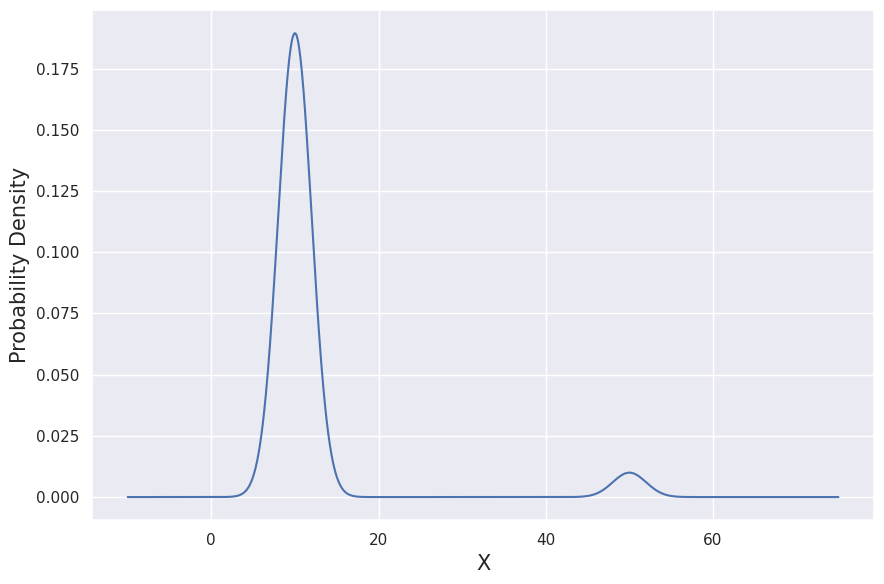

In [4]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(xs, gmm_1D.prob(xs))
ax.set(ylabel="Probability Density", xlabel="X")

plt.tight_layout()
# plt.savefig("score_analyses/gmm1d_nopts.png", dpi=200)

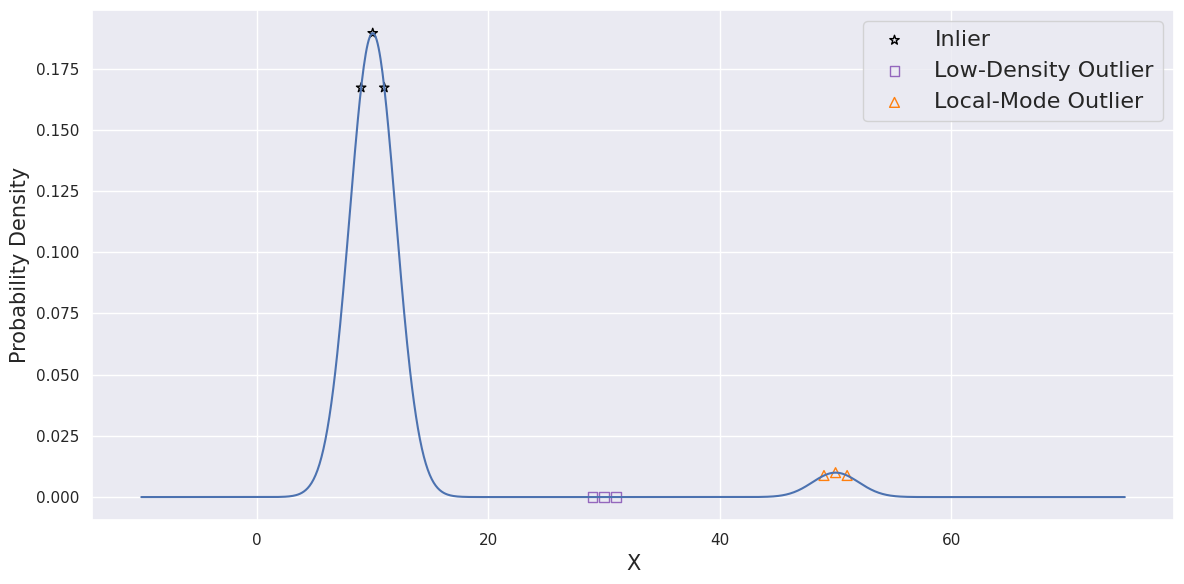

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(xs, gmm_1D.prob(xs))

keypoints = np.array([9,10,11, 29,30,31, 49,50,51], dtype=np.float32)
regions = ["Inlier"]*3 + ["Low-Density Outlier"]*3 + ["Local-Mode Outlier"]*3
colors = ["black"]*3 + ["tab:purple"]*3 + ["tab:orange"]*3
markers = ["*"]*3 + ["s"]*3 + ["^"]*3


for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
    if i%3 != 0:
        l=""
    ax.scatter(kp, gmm_1D.prob(kp), marker=m, facecolors='none', edgecolors=c, label=l, s=50)
    
ax.set(ylabel="Probability Density", xlabel="X")
ax.legend()
plt.tight_layout()
# plt.savefig("score_analyses/gmm1d.png", dpi=200)

## Analaytical Score Norms

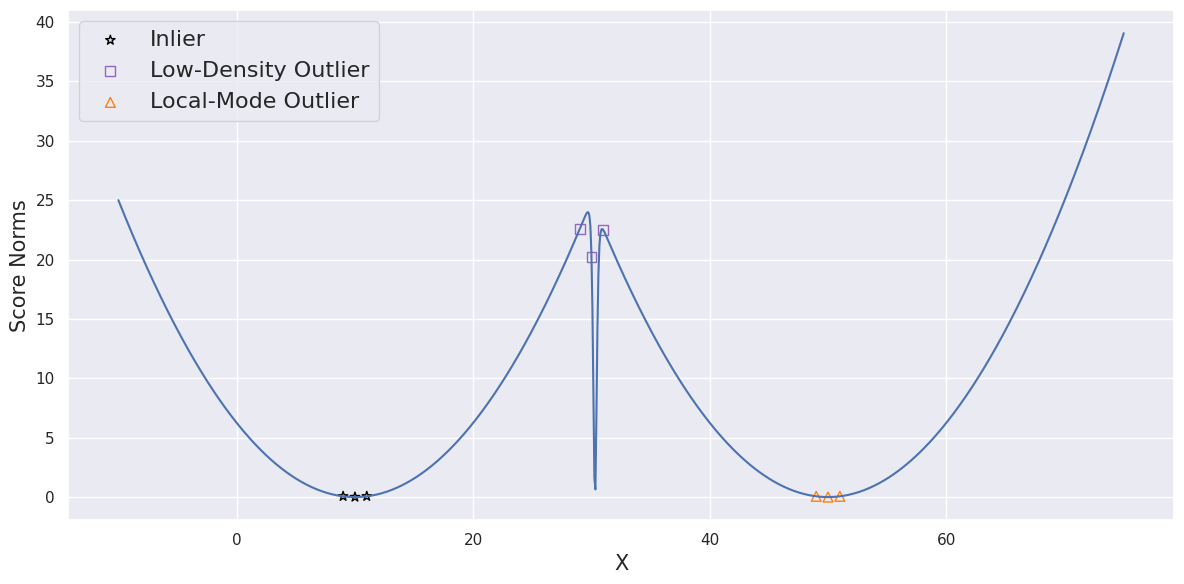

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

_grad_norms = analytic_log_prob_grad_1d(gmm_1D, xs) ** 2
_kp_norms = analytic_log_prob_grad_1d(gmm_1D, keypoints) ** 2

ax.plot(xs, _grad_norms)

for i, (kp, kpn, c, m, l) in enumerate(zip(keypoints, _kp_norms, colors, markers, regions)):
    if i%3 != 0: l=""
    ax.scatter(kp, kpn, marker=m, edgecolors=c, s=50, facecolors='none', label=l)

ax.set(ylabel="Score Norms", xlabel="X")
ax.legend()
plt.tight_layout()
# plt.savefig("score_analyses/score1d.png", dpi=200)

## Generating and Plotting Perturbed Distributions

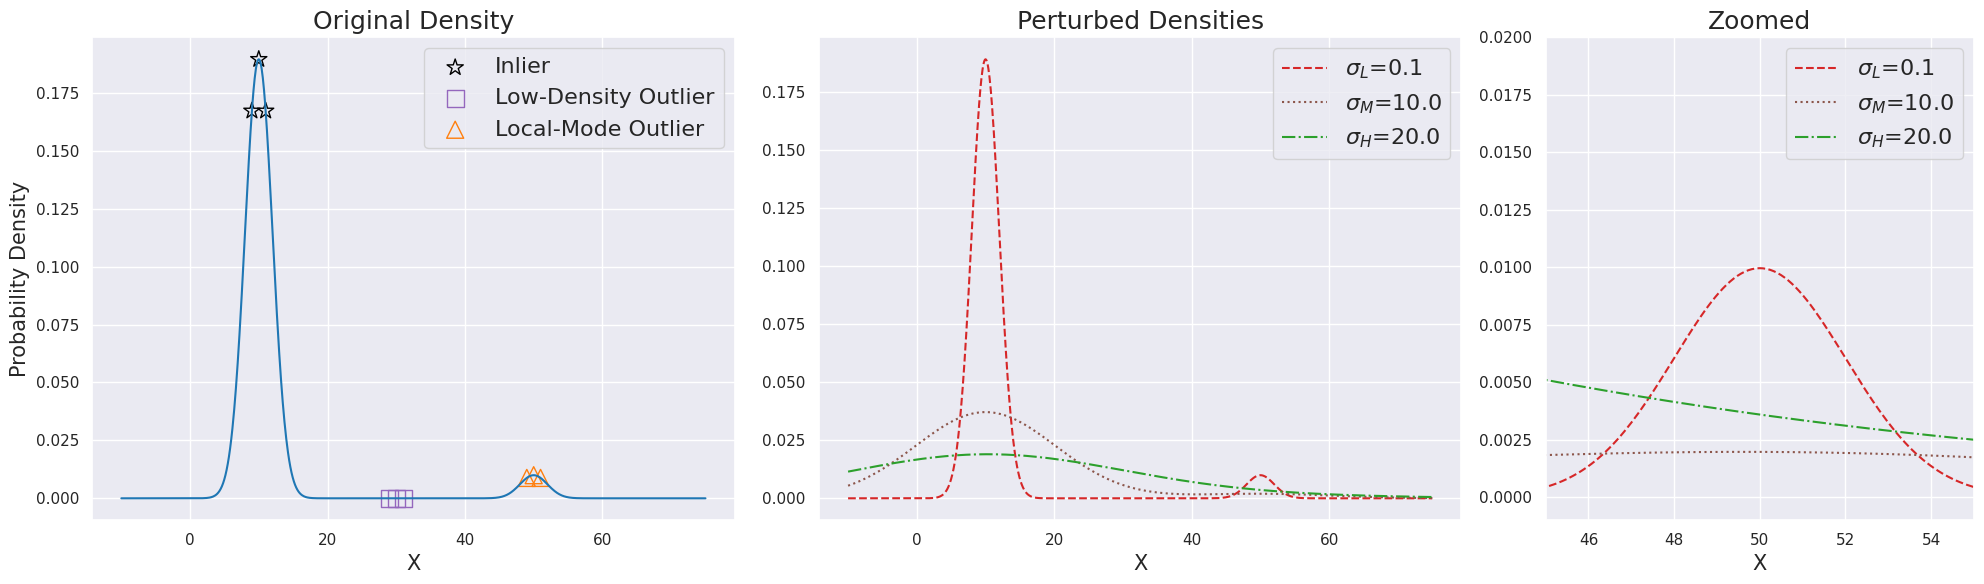

In [7]:
sigmas = [0.1,10,20]
pert_dists = []
fig, axs = plt.subplots(1,3, figsize=(20,6), gridspec_kw={'width_ratios': [3, 3, 2]})

plot_colors = ["tab:red", "tab:brown", "tab:green"]
linestyles = ["dashed", "dotted", "dashdot"]
sigma_label = ["L", "M", "H"]

axs[0].plot(xs, gmm_1D.prob(xs), c="tab:blue")
for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
    if i%3 != 0:
        l=""
    axs[0].scatter(kp, gmm_1D.prob(kp), marker=m, facecolors='none', edgecolors=c, label=l, s=150)
    
axs[0].set(ylabel="Probability Density", xlabel="X")
axs[0].legend()


for i, sigma_i in enumerate(sigmas):

    normals = tfd.Normal(
        loc=mus,
        scale = tf.math.sqrt(sigma_i**2 + scales**2)
    )

    gmm_1D_perturbed = tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=mix_probs),
                    components_distribution=normals
    )

    pert_dists.append(gmm_1D_perturbed)
    
    axs[1].plot(xs, gmm_1D_perturbed.prob(xs),
                label="$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])
    
    axs[2].plot(xs, gmm_1D_perturbed.prob(xs),
                label=r"$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])

#     for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
# #         if i%3 != 0:
#         l=""
#         axs[0].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
#         axs[1].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
    
for ax in axs:
    ax.set(xlabel="X")
    ax.legend()

axs[0].set_title("Original Density")
axs[1].set_title("Perturbed Densities")
axs[2].set_title("Zoomed")
axs[2].set(yscale="linear",
           ylim=(-0.001, 0.02), xlim=(45,55))

# axs[2].set(ylim=(-10, -4), xlim=(45,55))

plt.tight_layout()
# plt.savefig("Figures/gmm_plot.png", dpi=200)

### Alternate plot not used in paper

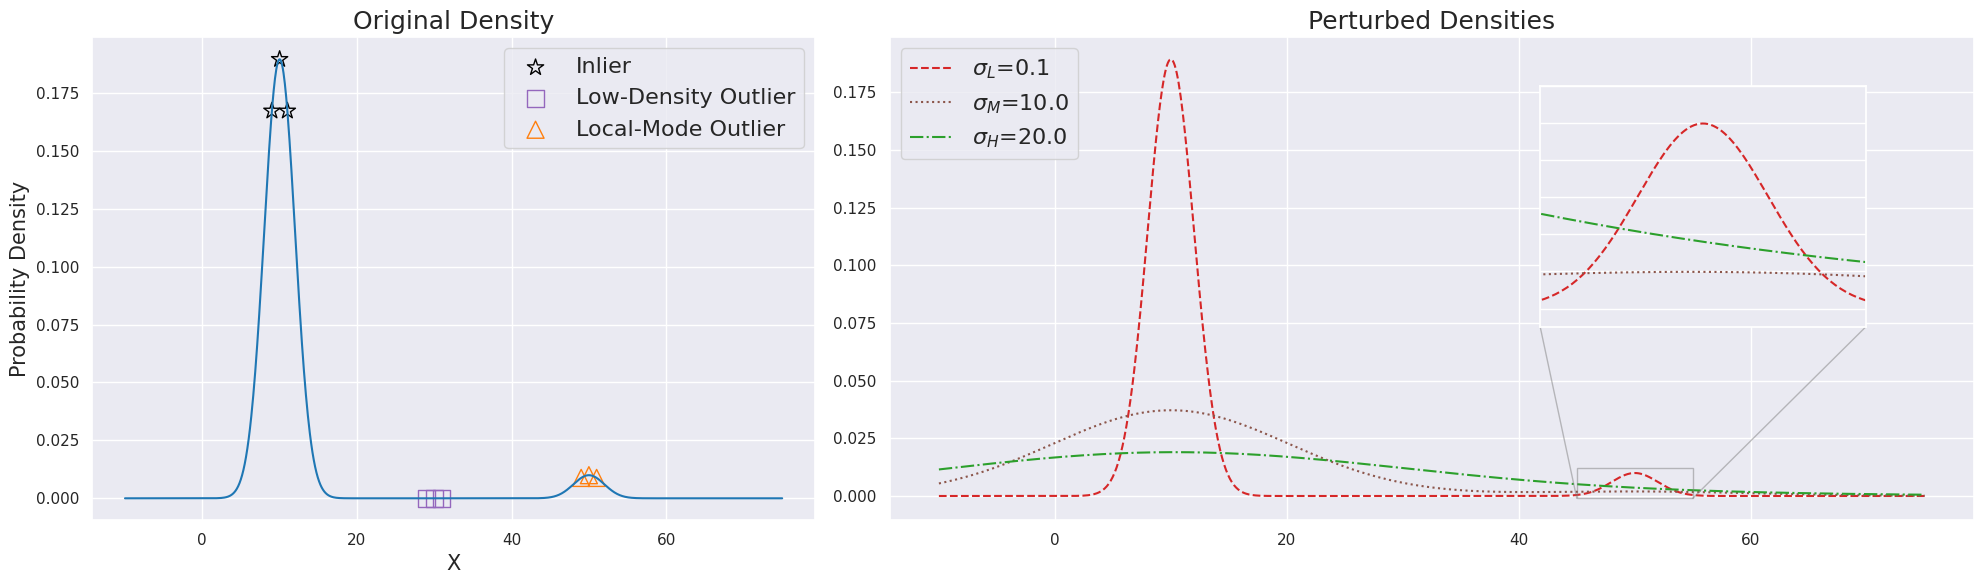

In [8]:
sigmas = [0.1,10,20]
pert_dists = []
fig, axs = plt.subplots(1,2, figsize=(20,6), gridspec_kw={'width_ratios': [2, 3]})

plot_colors = ["tab:red", "tab:brown", "tab:green"]
linestyles = ["dashed", "dotted", "dashdot"]
sigma_label = ["L", "M", "H"]

axs[0].plot(xs, gmm_1D.prob(xs), c="tab:blue")
for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
    if i%3 != 0:
        l=""
    axs[0].scatter(kp, gmm_1D.prob(kp), marker=m, facecolors='none', edgecolors=c, label=l, s=150)
    
axs[0].set(ylabel="Probability Density", xlabel="X")
axs[0].legend()


# inset axes....
# fig, ax = plt.subplots(1,1, figsize=(12,6))
axins = axs[1].inset_axes([0.6, 0.4, 0.3, 0.5])

for i, sigma_i in enumerate(sigmas):

    normals = tfd.Normal(
        loc=mus,
        scale = tf.math.sqrt(sigma_i**2 + scales**2)
    )

    gmm_1D_perturbed = tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=mix_probs),
                    components_distribution=normals
    )

    pert_dists.append(gmm_1D_perturbed)
    
    axs[1].plot(xs, gmm_1D_perturbed.prob(xs),
                label="$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])
    
    
    
    axins.plot(xs, gmm_1D_perturbed.prob(xs),
                label=r"$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])

#     for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
# #         if i%3 != 0:
#         l=""
#         axs[0].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
#         axs[1].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
    
ax.set(xlabel="X")
ax.legend()

axs[0].set_title("Original Density")
axs[1].set_title("Perturbed Densities")
axs[1].legend()
# axs[1].set_title("Zoomed")
axins.set(yscale="linear",
           ylim=(-0.001, 0.012), xlim=(45,55),
           xticks=[])
axins.yaxis.set_ticklabels([])
axs[1].indicate_inset_zoom(axins)

plt.tight_layout()
# plt.savefig("score_analyses/combined.png", dpi=200)

## Get Random Samples from GMM

CPU times: user 56.9 ms, sys: 3.51 ms, total: 60.4 ms
Wall time: 54.1 ms


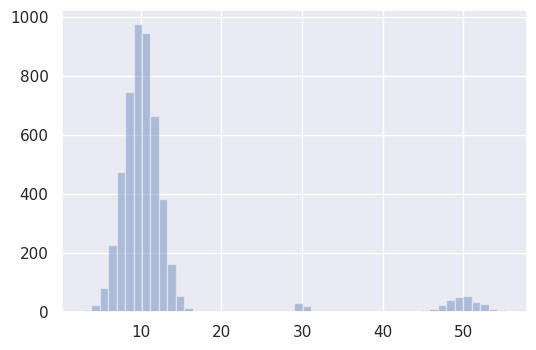

In [9]:
%%time
samples = gmm_1D.sample(5000).numpy()

samples = np.concatenate( (samples, np.random.uniform(29.0,31.0, 50))).astype(dtype=np.float32)

sns.distplot(samples, kde=False)

CPU times: user 109 ms, sys: 4.81 ms, total: 114 ms
Wall time: 110 ms


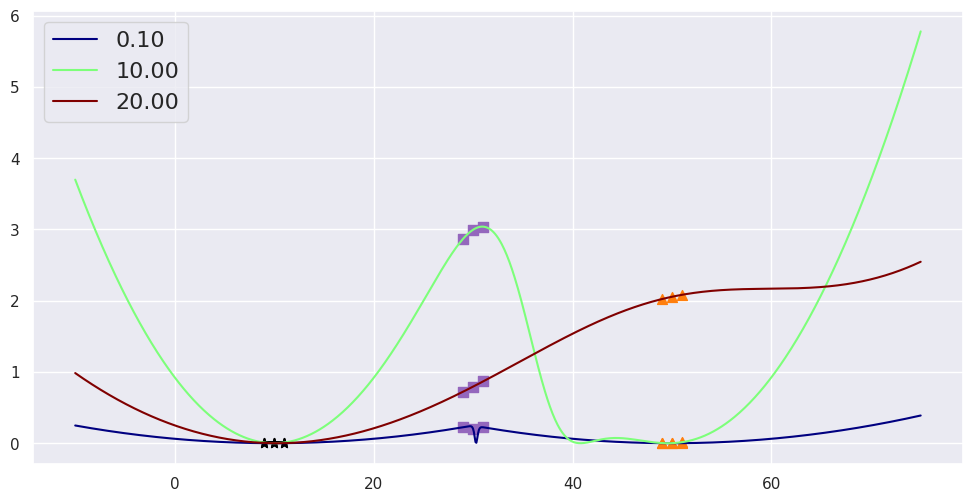

In [10]:
%%time
import matplotlib.pylab as pl

N = 3
estimates = []
keypoint_estimates = []
x_plot_grads = []

for s in sigmas:
    estimates.append(
        analytic_log_prob_grad_1d(gmm_1D, samples, sigma_i=s) ** 2 * s * s
    )
    keypoint_estimates.append(
        analytic_log_prob_grad_1d(gmm_1D, keypoints, sigma_i=s) ** 2 * s * s
    )
    x_plot_grads.append(
        analytic_log_prob_grad_1d(gmm_1D, xs, sigma_i=s) ** 2 * s * s
    )

estimates = np.stack(estimates)
keypoint_estimates = np.stack(keypoint_estimates)

_colors = pl.cm.jet(np.linspace(0,1,len(sigmas)))

fig, ax = plt.subplots(1,1, figsize=(12,6))
# ax.set(cmap="winter")

for i, (sigma, score) in enumerate(zip(sigmas, x_plot_grads)):
    ax.plot(xs, score, label="{:.2f}".format(sigma), color=_colors[i])
    for j, (kp, kpe) in enumerate(zip(keypoints, keypoint_estimates[i])):
        ax.scatter(kp, kpe, marker=markers[j], s=50, color=colors[j]) # c=keypoints, cmap=cm,
# ax.set(ylim=(-0.1,1), xlim=(60,80))
ax.legend()

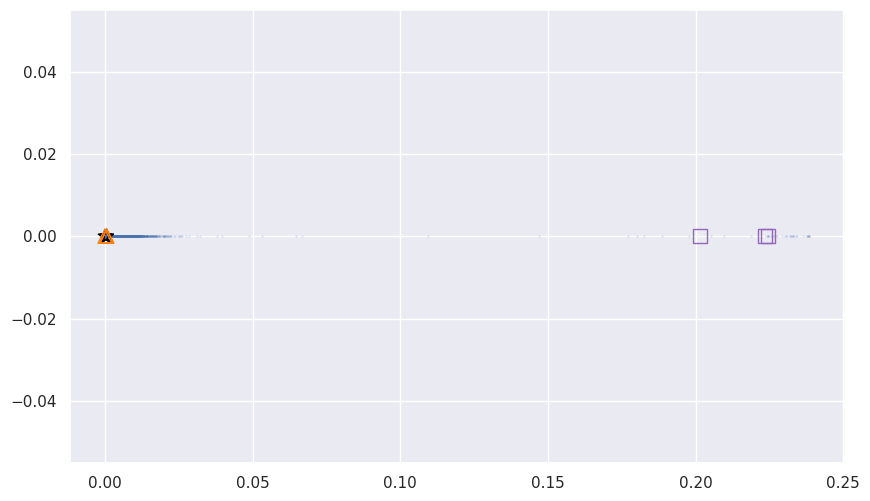

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(estimates[:1],np.zeros(estimates.shape[1]), s=1, alpha=0.1)

for i, kpe in enumerate(keypoint_estimates.T):
    ax.scatter(kpe[:1],0, marker=markers[i],  facecolors='none', edgecolors=colors[i], alpha=1, s=100 )
# ax.set(ylim)

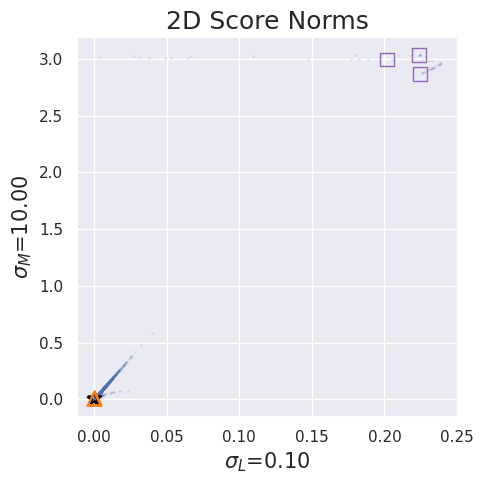

In [12]:
plt.close()

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(*estimates[:2], s=1, alpha=0.1)

for i, kp in enumerate(keypoint_estimates.T):
    ax.scatter(*kp[:2], marker=markers[i],  facecolors='none',
               edgecolors=colors[i], alpha=1, s=100)

ax.set(
    xlabel=r'$\sigma_L$={:.2f}'.format(sigmas[0]), 
    ylabel=r'$\sigma_M$={:.2f}'.format(sigmas[1])
)

plt.title("2D Score Norms")
# plt.legend()
plt.tight_layout()
# plt.savefig("score_analyses/scatter_2d_white.png", dpi=200, bbox_inches='tight')
plt.show()

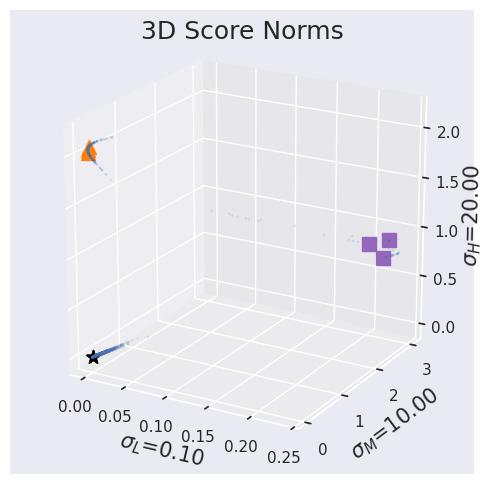

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*estimates, s=1, alpha=0.1)

for i, kp in enumerate(keypoint_estimates.T):
    ax.scatter(*kp, marker=markers[i], c=colors[i], alpha=1, s=100 )

# rotate the axes and update
ax.view_init(20, -60)
xmax=0.02
ax.set(
    xlabel=r'$\sigma_L$={:.2f}'.format(sigmas[0]), 
    ylabel=r'$\sigma_M$={:.2f}'.format(sigmas[1]),
    zlabel=r'$\sigma_H$={:.2f}'.format(sigmas[2]),
    yticks=np.arange(0.0, 3.1, 1.0)
)
plt.title("3D Score Norms")
plt.tight_layout()
# plt.savefig("score_analyses/scatter_3d_white.png", dpi=200 ,bbox_inches='tight')
plt.show()